# Section 3.5 Case scenario: in-depth investigation of the long term potentiation pathway in the context of schizophrenia

In [1]:
import getpass
import itertools
import json
import os
import random
import sys
import time
from itertools import chain, product, combinations

import igraph
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyobo
import seaborn as sns
from matplotlib import colors
from matplotlib.lines import Line2D
from network_utils import create_network_from_edge_file, edge_file_path
from tqdm import tqdm

In [2]:
getpass.getuser()

'rfigueiredo'

In [3]:
sys.version

'3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
time.asctime()

'Mon Mar  1 12:00:30 2021'

##### Increase figure quality

In [5]:
mpl.rcParams['figure.dpi'] = 320

## Instructions to reproduce this case scenario with a different disease and pathway

- for the selected disease, once again run the script in ../R/7_DEgenes.R with these code alterations:
    - remove the adj. *p* value cutoff of .05 (comment out line 90)
    - the variable groupIDS is a list of all DOIDs, replace this with just the DOID of your selected disease
    - on line 96, save this as DEgenes_full.tsv instead of DEgenes.tsv
- for the selected pathway, download the graph tsv from PathMe [example](https://pathme.scai.fraunhofer.de/api/pathway/?pathways%5B%5D=hsa04150&pathways%5B%5D=WP1471&pathways%5B%5D=R-HSA-165159&pathways%5B%5D=R-HSA-380972&pathways%5B%5D=R-HSA-165181&pathways%5B%5D=R-HSA-166208&resources%5B%5D=kegg&resources%5B%5D=wikipathways&resources%5B%5D=reactome&resources%5B%5D=reactome&resources%5B%5D=reactome&resources%5B%5D=reactome&format=csv)
    - remove the triple quotes and run the following cells, adjusting the path to the file and the pathway name

In [ ]:
"""graph = "path/to/graph.tsv"
pathway_name = "pathway"
df = pd.read_csv(graph, sep='\t', header=None)"""

In [ ]:
"""def parse_composite(complex_node):
    complex_node = complex_node.replace('act(composite(', '').replace('composite(', '')
    
    nodes = []
    
    for node in complex_node.split(','):
        nodes.append(node.replace('p(HGNC:', '').replace(')', '').strip())
        
    return nodes"""

In [ ]:
"""GRAPH = []

for source, relation, target, _ in df.values:
    
    if relation == 'hasComponent':
        continue
    
    if source.startswith('a(CHEBI:"') or 'pmod(Ph' in source or 'pmod(Ph' in target:
        continue
    
    if source.startswith('composite') or source.startswith('act(composite'):
        source = parse_composite(source)
    else:
        source = source.replace('p(HGNC:', '').replace(')', '').strip()

    
    if target.startswith('composite') or target.startswith('act(composite'):
        target = parse_composite(target)
        
    else:
        target = target.replace('p(HGNC:', '').replace(')', '').replace('act(', '').replace(')', '').strip()
        
    GRAPH.append({
        'source': source, 'relation': relation, 'target': target
    })"""

In [ ]:
"""final = pd.DataFrame(GRAPH)
final.to_csv(os.path.join('../data/pathway', f'{pathway_name}.tsv', sep='\t', index=False)"""

## Load data
#### download data from https://doi.org/10.5281/zenodo.4572853 and place the folder 'data/' in the root of the repository, or if placed elsewhere, write the full path to 'data/' as the variable data_dir below

#### optional: select your desired location of the output figures

#### TODO write the pathway name and DOID in the appropriate cells below

In [6]:
# replace here the location of the data dir if not structured as instructed
data_dir = "../data"

# optional, replace here the desired location of the output figures
figures_dir = os.path.join(os.path.expanduser("~"), "coexpath_figures")
os.makedirs(figures_dir, exist_ok=True)

##### Chosen disease - schizophrenia

In [7]:
doid = "5419"

##### Chosen pathway - Long term potentiation

In [8]:
pathway_name = "long_term_potentiation"

##### Load co-expression network for chosen disease

In [9]:
net = create_network_from_edge_file(edge_file_path(os.path.join(data_dir, "final_coexprNets"), doid), doid)

##### Load differentially expressed genes for chosen disease

In [10]:
DEgenes_dir = os.path.join(data_dir,"DEgenes")

DEgenes = pd.read_table(os.path.join(DEgenes_dir, doid, "DEgenes_full.tsv"),index_col="HGNC",usecols=["HGNC","adj.P.Val","logFC"])

##### Load chosen pathway

In [11]:
pathway_edges = pd.read_table(os.path.join(data_dir, "pathway", f"{pathway_name}.tsv"))

## Prepare data

##### Select the edges from the dataframe

In [12]:
edges = list(zip(pathway_edges.source,pathway_edges.target))

##### Select all the unique nodes and adjust data type for composite nodes

In [13]:
all_nodes = []
ind_proteins = []
complex_nodes = []
for node in set(chain(pathway_edges.source,pathway_edges.target)):
    if "[" in node:
        complex_nodes.append(node)
        nodes = eval(node)
        all_nodes.append(nodes)
        for prot in nodes:
            ind_proteins.append(prot)
    else:
        all_nodes.append(node)
        ind_proteins.append(node)

##### Idendify the nodes that we have the fold change values for

In [29]:
DEgenes_in_pathway = []
for node in ind_proteins:
    if node in DEgenes.index:
        DEgenes_in_pathway.append(node)

##### Identify the edges which are also in the co-expr. network

In [15]:
all_combos = [sorted((n1,n2)) for n1, n2 in combinations(ind_proteins, 2)]

edges_in_common = []
for i, (source, relation, target) in pathway_edges.iterrows():
    if "[" in source: 
        source = eval(source) # turn string into list of nodes 
    else: 
        source = [source]
    if "[" in target: 
        target = eval(target) # turn string into list of nodes
    else:
        target = [target]
    combos_true = 0 # in net
    combos_false = 0 # not in net
    for n1,n2 in product(source,target):
        n1, n2 = sorted((n1, n2))
        if (n1,n2) in all_combos:
            all_combos.remove((n1,n2)) # remove from consideration in next step
        if net.has_edge(n1,n2):
            combos_true +=1
        else:
            combos_false +=1
    if combos_true: edges_in_common.append((str(source),str(target)))
print(len(edges_in_common), "edges found out of", i+1)

5 edges found out of 35


##### Save the edges from all possible combinations which where not in the pathway

In [16]:
edges_not_in_pathway = all_combos

##### Map individual proteins to node in pathway

In [17]:
comp_nodes = {}
for node in all_nodes:
    if type(node) == str:
        comp_nodes[node] = [node]
    else:
        for sub_node in node:
            comp_nodes[sub_node] = node


##### From the edges not in the pathway, find those which can be found in co-expression network

In [18]:
new_edges_from_coexp_net = []
for n1,n2 in edges_not_in_pathway:
    if net.has_edge(n1,n2):
        n1,n2 = comp_nodes[n1],comp_nodes[n2]
        if n1 != n2:
            new_edges_from_coexp_net.append((n1,n2))

##### Remove duplicates from new edges

In [19]:
new_edges_from_coexp_net.sort()
new_edges_from_coexp_net = list(k for k,_ in itertools.groupby(new_edges_from_coexp_net))

##### Map the new edges from the co-expression network to any composite nodes they appear as in the pathway

In [20]:
edges_to_add = []
for n1,n2 in new_edges_from_coexp_net:
    if len(n1) == 1:
        n1 = n1[0]
    if len(n2) == 1:
        n2 = n2[0]
    if (str(n1),str(n2)) not in edges and (str(n2),str(n1)) not in edges:
        edges_to_add.append((str(n1),str(n2)))

##### Map the protein families to their name for labelling.
TODO : must be done manually

In [21]:
complex_node_names = {
    "['HRAS', 'KRAS', 'NRAS']": "Ras",
    "['GRIA1', 'GRIA2']": "AMPAR", 
    "['GRM1', 'GRM5']": "mGluR",
    "['MAP2K1', 'MAP2K2']": "MEK1/2",
    "['PPP3CA', 'PPP3CB', 'PPP3CC', 'PPP3R1', 'PPP3R2']": "CaN",
    "['PLCB1', 'PLCB2', 'PLCB3', 'PLCB4']": "PLC",
    "['ARAF', 'BRAF', 'RAF1']": "Raf",
    "['MAPK1', 'MAPK3']": "ERK1/2",
    "['ITPR1', 'ITPR2', 'ITPR3']": "IP3R",
    "['PRKCA', 'PRKCB', 'PRKCG']": "PKC",
    "['CALM1', 'CALM2', 'CALM3', 'CALML3', 'CALML4', 'CALML5', 'CALML6']": "CaM",
    "['CREBBP', 'EP300']": "CBP",
    "['PRKACA', 'PRKACB', 'PRKACG']": "PKA",
    "['RAP1A', 'RAP1B']": "Rap1",
    "['GRIN1', 'GRIN2A', 'GRIN2B', 'GRIN2C', 'GRIN2D']": "NMDAR",
    "['CAMK2A', 'CAMK2B', 'CAMK2D', 'CAMK2G']": "CaMKII",
    "['PPP1CA', 'PPP1CB', 'PPP1CC']": "PP1",
    "['RPS6KA1', 'RPS6KA2', 'RPS6KA3', 'RPS6KA6']": "Rsk",
    "['ADCY1', 'ADCY8']": "AC1/8",
}

## Figure : Long term potentiation (LTP) pathway in the context of schizophrenia

In [22]:
names = [str(node) for node in all_nodes]
names.extend([str(node) for node in ind_proteins if str(node) not in names])

In [44]:
ORANGE = "#E7745B"
LIGHT_ORANGE = "#F7B89C"
BLUE = "#7093F3"
LIGHT_BLUE = "#AAC7FD"
LIGHT_GRAY = "#C6C6C6"
DARK_GRAY = "#BDBDBD"
DARK = "#414449"
RED = "#FF0000"
DARK_BLUE = "#0000FF"
PURPLE = "#8A2BE2"
GREEN = "#008000"

BASE_VISUAL_STYLE = {
    "bbox": (3000, 3000),
    "margin": 300,
    "vertex_label_size": 35,
    "edge_curved": False,
    "vertex_label_dist": 2,
}

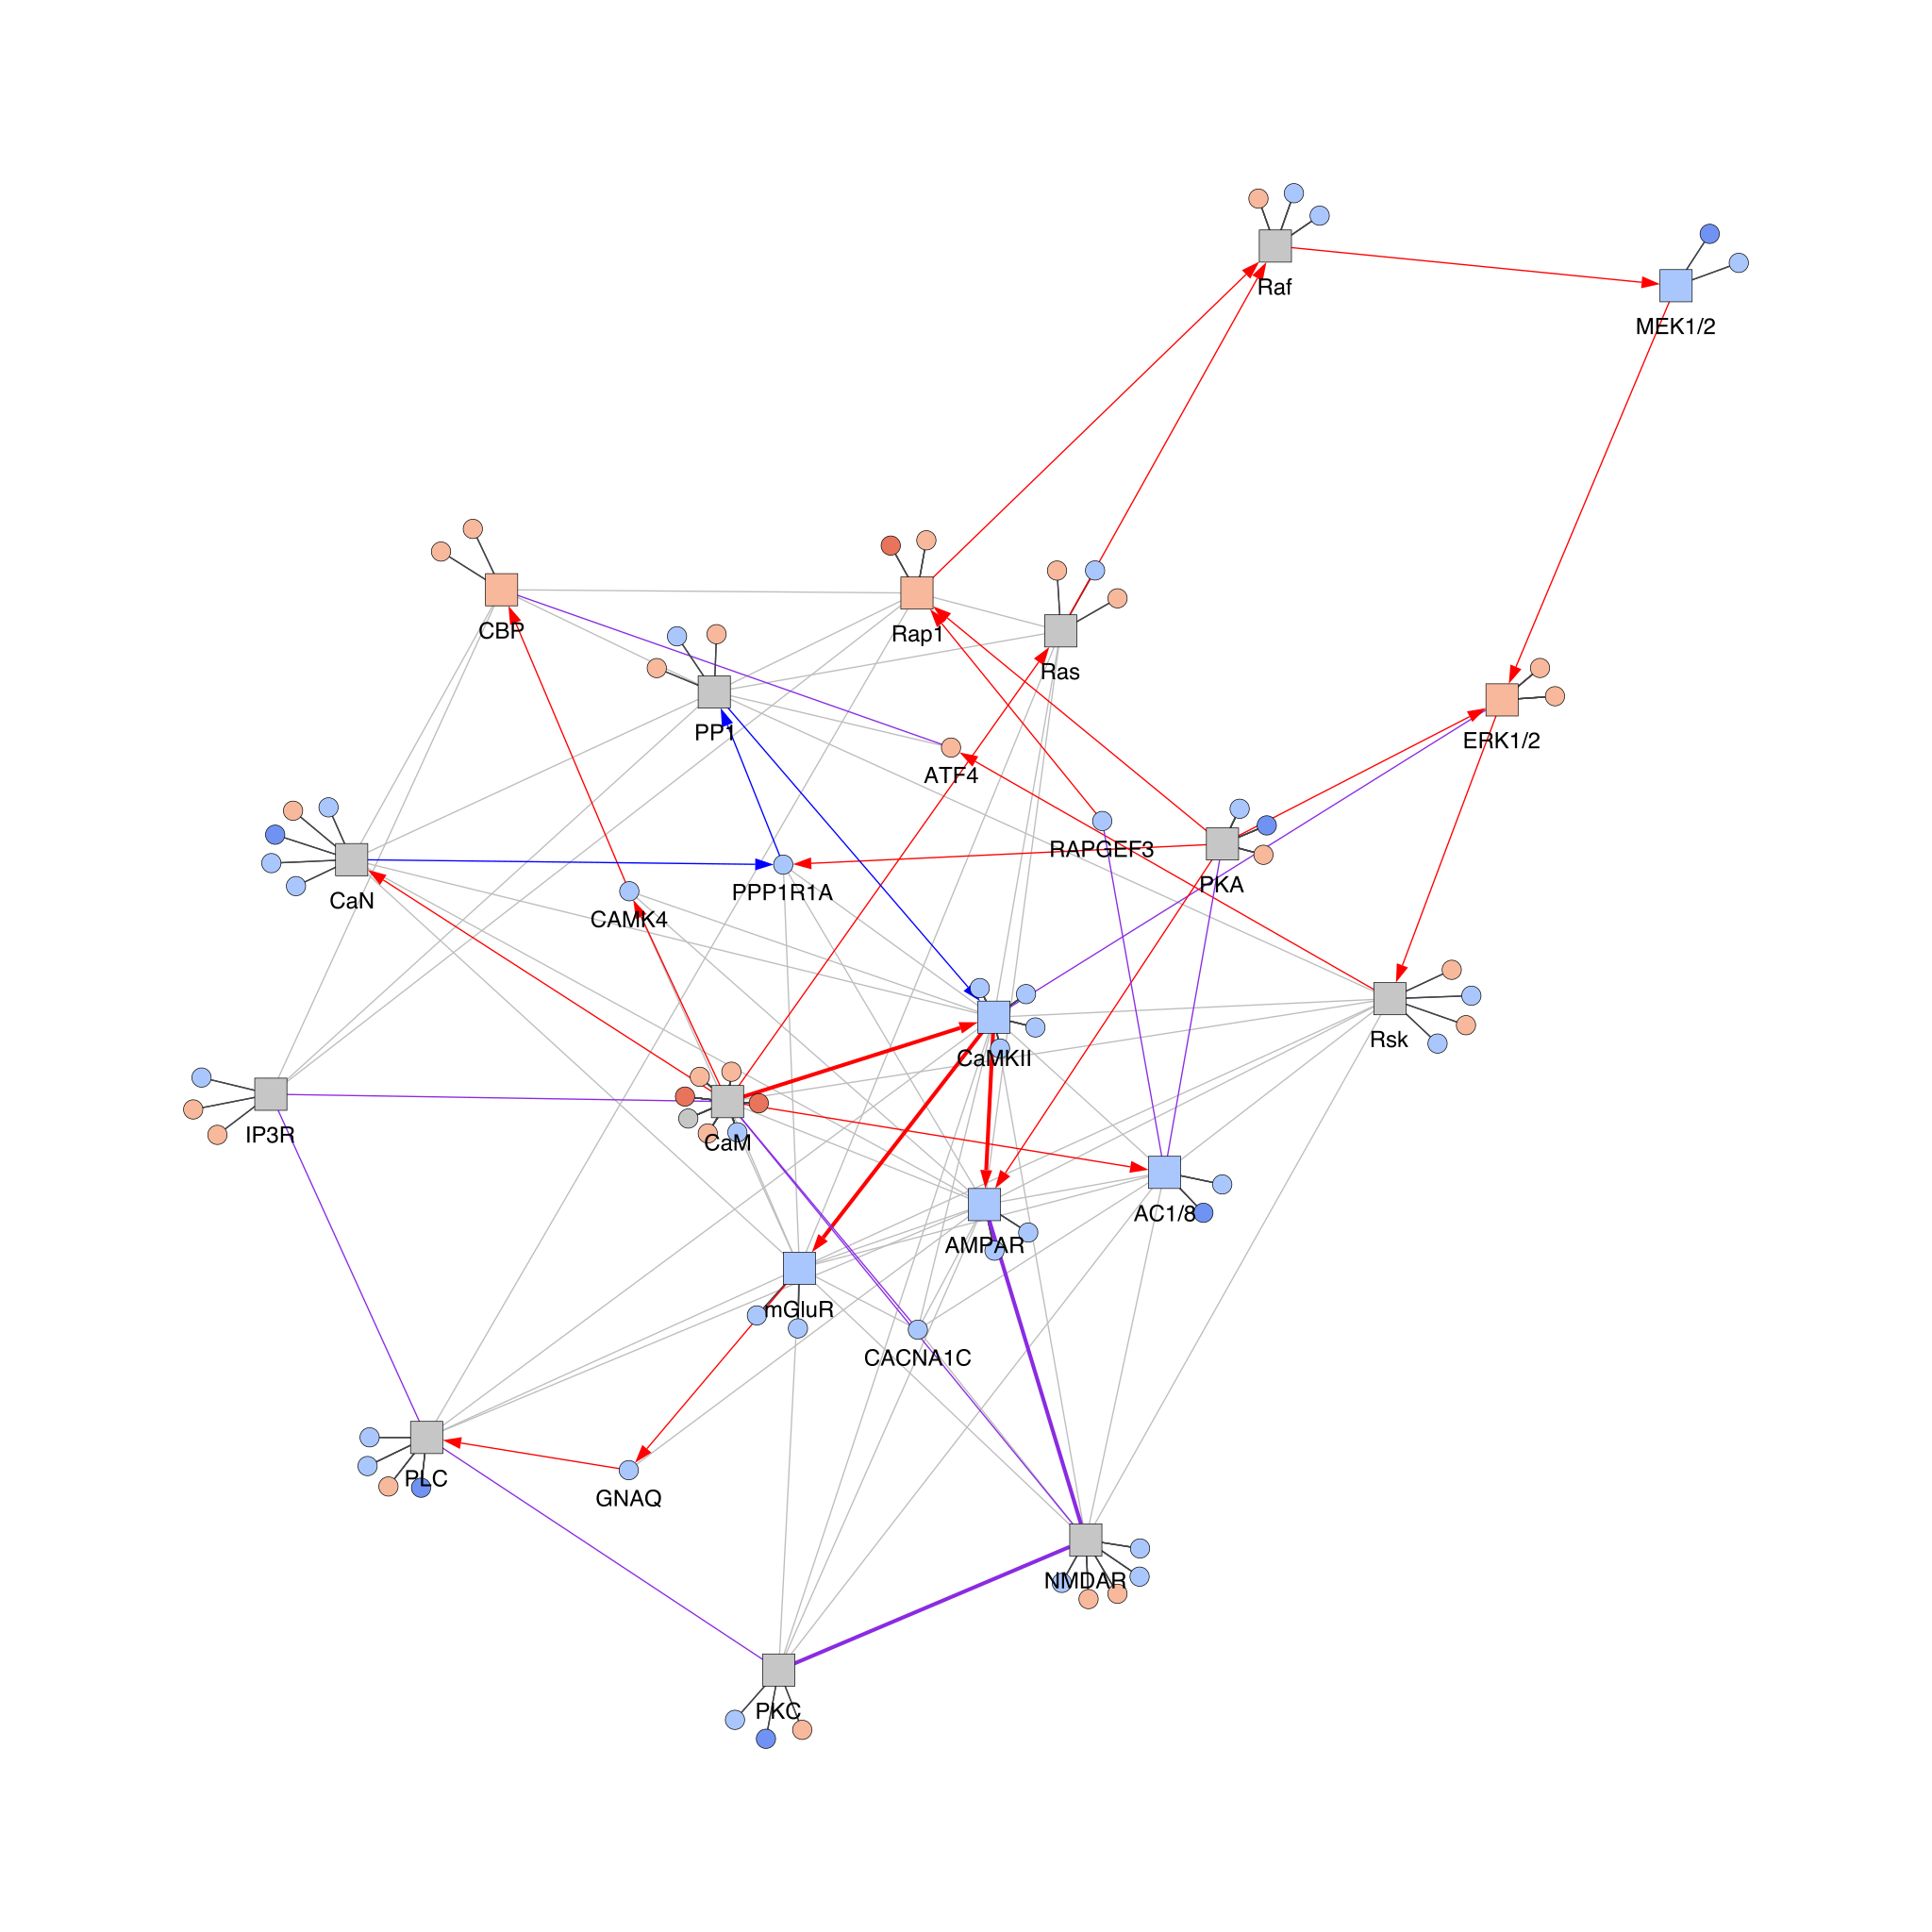

In [51]:
pathway = igraph.Graph(directed=True)
pathway.add_vertices(names)

for n1,n2 in edges_to_add:
    pathway.add_edge(n1,n2, weight=.5)

for i, (source, relation, target) in pathway_edges.iterrows():
    if "[" in source: 
        for node in eval(source):
            pathway.add_edge(source, node, weight=30, relation = "has component") # edges for composite nodes should be tight
    if "[" in target: 
        for node in eval(target):
            pathway.add_edge(target, node, weight=30, relation = "has component") # edges for composite nodes should be tight
    pathway.add_edge(source,target,weight=2, relation=relation)
    
node_ids = {}
for idx, node in enumerate(pathway.vs):
    if "[" in node["name"]:
        pathway.vs[idx]["size"] = 50
        pathway.vs[idx]["shape"] = "rect"
        pathway.vs[idx]["label"] = complex_node_names[node["name"]]
    else:
        pathway.vs[idx]["size"] = 30
        pathway.vs[idx]["label"] = node["name"]
        node_ids[node["name"]] = idx
    if node["name"] in DEgenes_in_pathway:
        if DEgenes.loc[node["name"]]["adj.P.Val"] <= .05:
            if DEgenes.loc[node["name"]]["logFC"] > 0:
                pathway.vs[idx]["color"] = ORANGE
            else: 
                pathway.vs[idx]["color"] = BLUE
        else:
            if DEgenes.loc[node["name"]]["logFC"] > 0:
                pathway.vs[idx]["color"] = LIGHT_ORANGE
            else: 
                pathway.vs[idx]["color"] = LIGHT_BLUE
    else: 
        pathway.vs[idx]["color"] = LIGHT_GRAY
        
for idx, node in enumerate(pathway.vs):
    if "[" in node["name"]:
        sub_colors = [pathway.vs[node_ids[sub_node]]["color"] for sub_node in eval(node["name"]) if pathway.vs[node_ids[sub_node]]["color"] != LIGHT_GRAY]
        if sub_colors:
            if all([color in {ORANGE, LIGHT_ORANGE} for color in sub_colors]):
                pathway.vs[idx]["color"] = LIGHT_ORANGE
            elif all([color in {BLUE, LIGHT_BLUE} for color in sub_colors]):
                pathway.vs[idx]["color"] = LIGHT_BLUE
        for sub_node in eval(node["name"]):
            pathway.vs[node_ids[sub_node]]["label"] = " "
            
for idx, edge in enumerate(pathway.es):
    pathway.es[idx]["color"] = DARK
    pathway.es[idx]["width"] = 2
    rel = pathway.es[idx]["relation"]
    if (edge.source_vertex["name"], edge.target_vertex["name"]) in edges_to_add \
    or (edge.target_vertex["name"], edge.source_vertex["name"]) in edges_to_add:
        pathway.es[idx]["color"] = DARK_GRAY
        pathway.es[idx]["arrow_size"] = 0
    if (edge.source_vertex["name"], edge.target_vertex["name"]) in edges_in_common:
        pathway.es[idx]["width"] = 6
        pathway.es[idx]["color"] = "black"
        #if rel in {"increases", "decreases"}:
            #pathway.es[idx]["arrow_size"] = 2
    if rel == "increases": 
        pathway.es[idx]["color"] = RED
        pathway.es[idx]["arrow_size"] = 2
    elif rel == "decreases": 
        pathway.es[idx]["color"] = DARK_BLUE
        pathway.es[idx]["arrow_size"] = 2
    elif rel == "regulates": 
        pathway.es[idx]["color"] = GREEN
        pathway.es[idx]["arrow_size"] = 2
    elif rel == "association": 
        pathway.es[idx]["color"] = PURPLE
        pathway.es[idx]["arrow_size"] = 0
    elif rel == "has component": 
        pathway.es[idx]["arrow_size"] = 0
    

visual_style = BASE_VISUAL_STYLE.copy()
random.seed(12345)
visual_style["layout"] = pathway.layout('fruchterman_reingold', niter=5000, weights="weight")

igraph.plot(pathway, target= os.path.join(figures_dir, "LTP_pathway_and_schizophrenia.png"), **visual_style)

##### Make the legend (must be added manually)

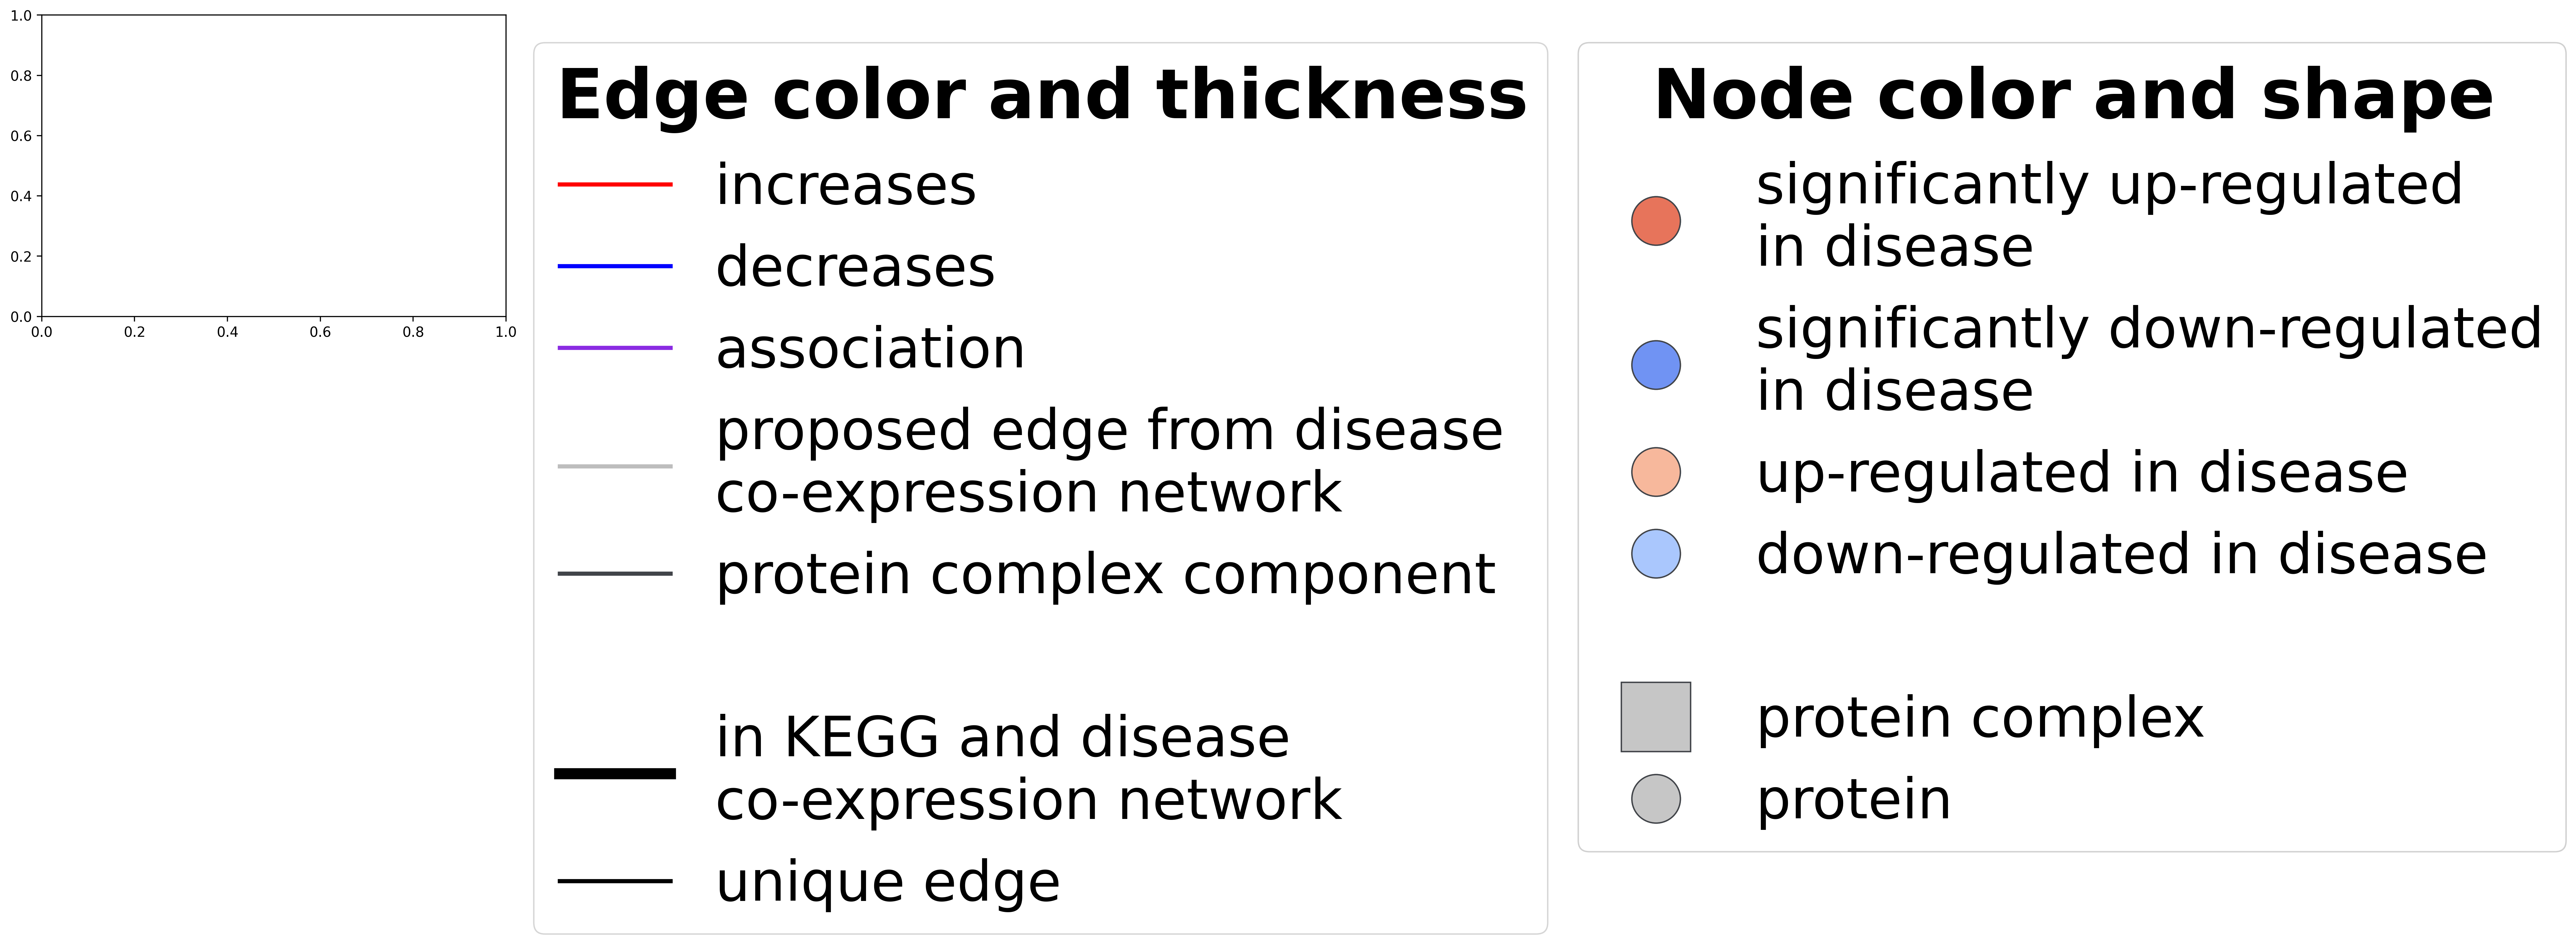

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)

legend_elements = [
    Line2D([0], [0], lw=3, color= RED, label="increases"),
    Line2D([0], [0], lw=3, color= DARK_BLUE, label="decreases"),
    # TODO: uncomment if the pathway contains 'regulates' edges
    #Line2D([0], [0], lw=3, color= GREEN, label="regulates"),
    Line2D([0], [0], lw=3, color= PURPLE, label="association"),
    Line2D([0], [0], lw=3, color=DARK_GRAY, label="proposed edge from disease \nco-expression network"),
    Line2D([0], [0], lw=3, color=DARK, label="protein complex component"),
    Line2D([0], [0], lw=0, label=""),
    Line2D([0], [0], lw=8, color="black", label="in KEGG and disease \nco-expression network"),
    Line2D([0], [0], lw=3, color="black", label="unique edge"),
]
l1 = ax.legend(handles = legend_elements,bbox_to_anchor=(1,1), loc='upper left', 
               title = r'$\bf{Edge}$ $\bf{color}$ $\bf{and}$ $\bf{thickness}$', title_fontsize=50, prop={'size': 40})

legend_elements = [
    Line2D([0], [0], lw=0, marker= "o", ms= 35, mec = DARK, color=ORANGE, label="significantly up-regulated\nin disease"),
    Line2D([0], [0], lw=0, marker= "o", ms= 35, mec = DARK, color=BLUE, label="significantly down-regulated\nin disease"),
    Line2D([0], [0], lw=0, marker= "o", ms= 35, mec = DARK, color=LIGHT_ORANGE, label="up-regulated in disease"),
    Line2D([0], [0], lw=0, marker= "o", ms= 35, mec = DARK, color=LIGHT_BLUE, label="down-regulated in disease"),
    Line2D([0], [0], lw=0, label=""),
    Line2D([0], [0], lw=0, marker= "s", ms= 50, mec = DARK, color=LIGHT_GRAY, label="protein complex"),
    Line2D([0], [0], lw=0, marker= "o", ms= 35, mec = DARK, color=LIGHT_GRAY, label="protein"),
]
l2 = ax.legend(handles = legend_elements,bbox_to_anchor=(3.25,1), loc='upper left', 
               title = r'$\bf{Node}$ $\bf{color}$ $\bf{and}$ $\bf{shape}$', title_fontsize=50, prop={'size': 40})

ax.add_artist(l1)
ax.add_artist(l2)
plt.savefig(os.path.join(figures_dir, "LTP_pathway_and_schizophrenia_legend.png"), bbox_inches='tight', dpi=210)